In [1]:
from boto.s3.connection import S3Connection
import pyart
import gzip
from matplotlib import pyplot as plt
import shutil, os
from datetime import timedelta, datetime
import tempfile
%matplotlib inline

/Users/scollis/anaconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/Users/scollis/anaconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/Users/scollis/anaconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  use `figure_formats` instead)""")
/Users/scollis/anaconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:95: DeprecationWarning: metadata {'config': True} was set from the c

In [59]:
def nearestDate(dates, pivot):
    return min(dates, key=lambda x: abs(x - pivot))


def get_radar_from_aws(site, datetime_t):
    """
    Get the closest volume of NEXRAD data to a particular datetime.
    Parameters
    ----------
    site : string
        four letter radar designation 
    datetime_t : datetime
        desired date time
    """
    
    #First create the query string for the bucket knowing
    #how NOAA and AWS store the data
    
    my_pref = datetime_t.strftime('%Y/%m/%d/') + site
    
    #Connect to the bucket
    
    conn = S3Connection(anon = True)
    bucket = conn.get_bucket('noaa-nexrad-level2')
    
    #Get a list of files 
    
    bucket_list = list(bucket.list(prefix = my_pref))
    
    #we are going to create a list of keys and datetimes to allow easy searching
    
    keys = []
    datetimes = []
    
    #populate the list

    for i in range(len(bucket_list)):
        this_str = str(bucket_list[i].key)
        if 'gz' in this_str:
            endme = this_str[-22:-3]
            fmt = '%Y%m%d_%H%M%S_V06' 
            dt = datetime.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])
            #print(dt)
    
    #function to allow easy searching 
    
    def func(x):
        delta =  x - datetime_t if x > datetime_t else timedelta.max
        return delta
    
    #find the closest available radar to your datetime 
    
    closest_datetime = nearestDate(datetimes, datetime_t)
    index = datetimes.index(closest_datetime)
    #print(closest_datetime)
    #create a temp file, download radar data to file from S3
    #read into a radar object and return
    
    localfile = tempfile.NamedTemporaryFile()
    keys[index].get_contents_to_filename(localfile.name)
    radar = pyart.io.read(localfile.name)
    return radar

ERROR:boto:Caught exception reading instance data
Traceback (most recent call last):
  File "/Users/scollis/anaconda/lib/python2.7/site-packages/boto/utils.py", line 210, in retry_url
    r = opener.open(req, timeout=timeout)
  File "/Users/scollis/anaconda/lib/python2.7/urllib2.py", line 431, in open
    response = self._open(req, data)
  File "/Users/scollis/anaconda/lib/python2.7/urllib2.py", line 449, in _open
    '_open', req)
  File "/Users/scollis/anaconda/lib/python2.7/urllib2.py", line 409, in _call_chain
    result = func(*args)
  File "/Users/scollis/anaconda/lib/python2.7/urllib2.py", line 1227, in http_open
    return self.do_open(httplib.HTTPConnection, req)
  File "/Users/scollis/anaconda/lib/python2.7/urllib2.py", line 1197, in do_open
    raise URLError(err)
URLError: <urlopen error timed out>
ERROR:boto:Unable to read instance data, giving up


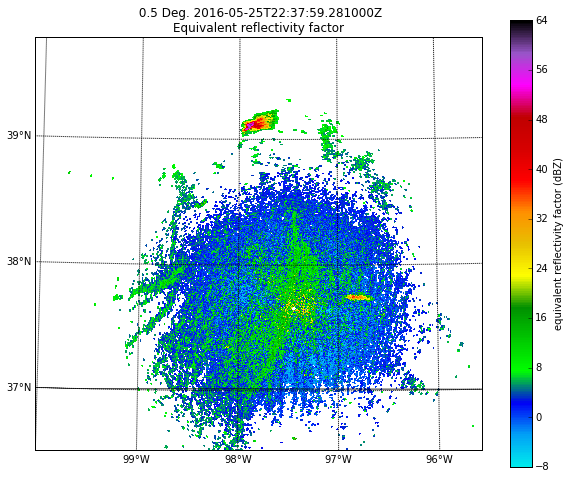

In [62]:
base_date = "20160525_225000"
fmt = '%Y%m%d_%H%M%S' 
b_d = datetime.utcnow() #datetime.strptime(base_date, fmt)

my_radar = get_radar_from_aws('KICT',b_d )
max_lat = 39.8
min_lat = 36.5
min_lon = -100
max_lon = -95.5

display = pyart.graph.RadarMapDisplay(my_radar)
fig = plt.figure(figsize = [10,8])
display.plot_ppi_map('reflectivity', sweep = 0, resolution = 'i',
                    vmin = -8, vmax = 64, mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef,
                    min_lat = min_lat, min_lon = min_lon,
                    max_lat = max_lat, max_lon = max_lon)

ERROR:boto:Caught exception reading instance data
Traceback (most recent call last):
  File "/Users/scollis/anaconda/lib/python2.7/site-packages/boto/utils.py", line 210, in retry_url
    r = opener.open(req, timeout=timeout)
  File "/Users/scollis/anaconda/lib/python2.7/urllib2.py", line 431, in open
    response = self._open(req, data)
  File "/Users/scollis/anaconda/lib/python2.7/urllib2.py", line 449, in _open
    '_open', req)
  File "/Users/scollis/anaconda/lib/python2.7/urllib2.py", line 409, in _call_chain
    result = func(*args)
  File "/Users/scollis/anaconda/lib/python2.7/urllib2.py", line 1227, in http_open
    return self.do_open(httplib.HTTPConnection, req)
  File "/Users/scollis/anaconda/lib/python2.7/urllib2.py", line 1197, in do_open
    raise URLError(err)
URLError: <urlopen error timed out>
ERROR:boto:Unable to read instance data, giving up


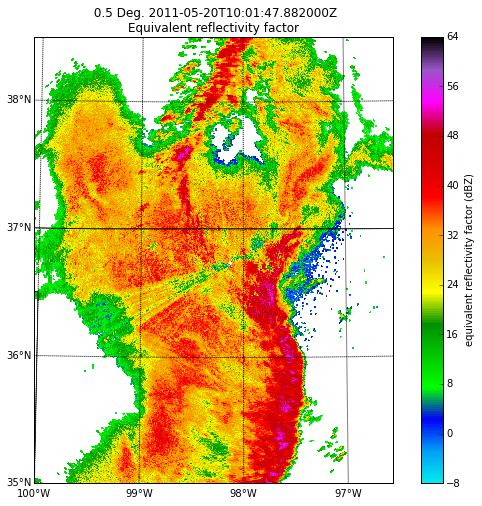

In [12]:
#Look at some special cases.

base_date = "20110520_100000"
fmt = '%Y%m%d_%H%M%S' 
b_d = datetime.strptime(base_date, fmt)

my_radar = get_radar_from_aws('KVNX',b_d )

min_lat = 35
max_lat = 38.5
min_lon = -100
max_lon = -96.5
display = pyart.graph.RadarMapDisplay(my_radar)
fig = plt.figure(figsize = [10,8])
display.plot_ppi_map('reflectivity', sweep = 0, resolution = 'i',
                    vmin = -8, vmax = 64, mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef,
                    min_lat = min_lat, min_lon = min_lon,
                    max_lat = max_lat, max_lon = max_lon)

ERROR:boto:Caught exception reading instance data
Traceback (most recent call last):
  File "/Users/scollis/anaconda/lib/python2.7/site-packages/boto/utils.py", line 210, in retry_url
    r = opener.open(req, timeout=timeout)
  File "/Users/scollis/anaconda/lib/python2.7/urllib2.py", line 431, in open
    response = self._open(req, data)
  File "/Users/scollis/anaconda/lib/python2.7/urllib2.py", line 449, in _open
    '_open', req)
  File "/Users/scollis/anaconda/lib/python2.7/urllib2.py", line 409, in _call_chain
    result = func(*args)
  File "/Users/scollis/anaconda/lib/python2.7/urllib2.py", line 1227, in http_open
    return self.do_open(httplib.HTTPConnection, req)
  File "/Users/scollis/anaconda/lib/python2.7/urllib2.py", line 1197, in do_open
    raise URLError(err)
URLError: <urlopen error timed out>
ERROR:boto:Unable to read instance data, giving up


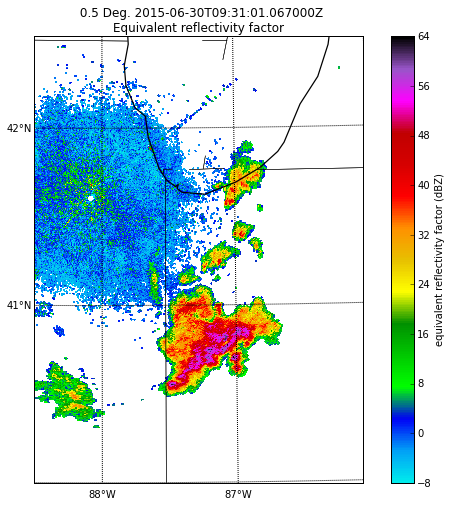

In [13]:
base_date = "20150630_093000"
fmt = '%Y%m%d_%H%M%S' 
b_d = datetime.strptime(base_date, fmt)

my_radar = get_radar_from_aws('KLOT',b_d )
max_lat = 42.5 
min_lat = 40
min_lon = -88.5 
max_lon = -86

display = pyart.graph.RadarMapDisplay(my_radar)
fig = plt.figure(figsize = [10,8])
display.plot_ppi_map('reflectivity', sweep = 0, resolution = 'i',
                    vmin = -8, vmax = 64, mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef,
                    min_lat = min_lat, min_lon = min_lon,
                    max_lat = max_lat, max_lon = max_lon)

ERROR:boto:Caught exception reading instance data
Traceback (most recent call last):
  File "/Users/scollis/anaconda/lib/python2.7/site-packages/boto/utils.py", line 210, in retry_url
    r = opener.open(req, timeout=timeout)
  File "/Users/scollis/anaconda/lib/python2.7/urllib2.py", line 431, in open
    response = self._open(req, data)
  File "/Users/scollis/anaconda/lib/python2.7/urllib2.py", line 449, in _open
    '_open', req)
  File "/Users/scollis/anaconda/lib/python2.7/urllib2.py", line 409, in _call_chain
    result = func(*args)
  File "/Users/scollis/anaconda/lib/python2.7/urllib2.py", line 1227, in http_open
    return self.do_open(httplib.HTTPConnection, req)
  File "/Users/scollis/anaconda/lib/python2.7/urllib2.py", line 1197, in do_open
    raise URLError(err)
URLError: <urlopen error timed out>
ERROR:boto:Unable to read instance data, giving up


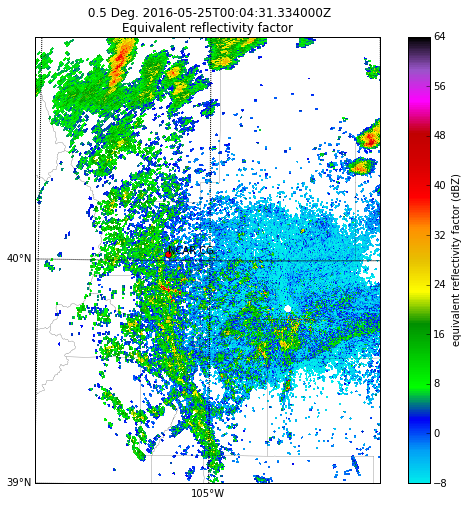

In [20]:
base_date = "20160525_195000"
fmt = '%Y%m%d_%H%M%S' 
b_d = datetime.strptime(base_date, fmt)

my_radar = get_radar_from_aws('KFTG',b_d )
max_lat = 41
min_lat = 39
min_lon = -106
max_lon = -104

display = pyart.graph.RadarMapDisplay(my_radar)
fig = plt.figure(figsize = [10,8])
display.plot_ppi_map('reflectivity', sweep = 0, resolution = 'i',
                    vmin = -8, vmax = 64, mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef, 
                     min_lat = min_lat, min_lon = min_lon,
                    max_lat = max_lat, max_lon = max_lon)
display.basemap.drawcounties()
display.plot_point( -105.2455834,40.0308768, 
                   label_text = 'NCAR CG', label_offset = (0.0,0.0) )


In [37]:
print(b_d)

2016-05-25 22:19:05.603485
